In [1]:
import numpy as np
import pandas as pd #to read files or work with dataframes
import yfinance as yf
import datetime as datetime #to specify start and end dates
import matplotlib.pyplot as plt #to visualize
from matplotlib import style
import pandas_datareader as dr #to collect data
from pandas_datareader import data
import cvxpy as cp
import cvxopt as opt
from cvxopt import blas, solvers
import scipy.optimize as sco

%matplotlib inline

In [2]:
#Parameter set up:
n_portfolios = 5000
n_days = 252
assets = ['ETH-GBP', 'BARC.L', 'GSK.L', 'BP.L', 'BATS.L', 'AVV.L', 'GLEN.L', 'SGRO.L', 'OCDO.L', 'JD.L', 'SGE.L', 'PSN.L', 'VOD.L', 'AHT.L', 'FERG.L', 'BA.L']
assets.sort()
start_date = '2020-01-01'
end_date = '2022-04-25'

n_assets = len(assets)

In [3]:
#Downloading stockprices from Yahoo Finance:
prices = yf.download(assets, start=start_date, end=end_date, adjusted=True)

[*********************100%***********************]  16 of 16 completed


In [4]:
#Calculation of Annualised Average Returns and the corresponding Standard Deviation:
returns = prices['Adj Close'].pct_change().dropna()
returns

,AHT.L,AVV.L,BA.L,BARC.L,BATS.L,BP.L,ETH-GBP,FERG.L,GLEN.L,GSK.L,JD.L,OCDO.L,PSN.L,SGE.L,SGRO.L,VOD.L
Date,,,,,,,,,,,,,,,,
2020-01-03,-0.006250,-0.004243,0.011847,-0.010259,0.026646,0.027451,0.058423,0.004013,0.002489,0.004052,-0.024296,0.004764,-0.016117,-0.012306,-0.004444,0.000947
2020-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.007966,-0.003835,0.013430,-0.012657,-0.000597,0.020342,0.051429,-0.014273,-0.022139,-0.007846,0.006410,0.004741,0.001117,-0.002980,-0.005580,-0.005813
2020-01-07,-0.002496,0.010265,0.002718,0.011935,0.016716,-0.010514,-0.000803,0.006082,0.002962,-0.004519,0.000490,0.042470,0.014132,-0.001358,-0.008530,-0.002856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-20,0.040070,0.015696,0.006053,0.021826,0.011291,0.000249,-0.012589,0.035122,-0.031180,-0.010684,0.010136,-0.053368,0.013730,-0.003055,0.007749,-0.014726
2022-04-21,0.008585,0.025214,-0.010942,0.007926,0.009203,0.004986,-0.026162,0.016965,-0.032022,0.002298,0.019031,0.007394,0.014447,0.012813,0.008422,0.000311
2022-04-22,-0.036952,-0.000793,0.005127,-0.022391,-0.001495,-0.024805,0.006721,-0.023170,-0.027568,-0.001605,-0.016638,-0.044037,-0.014241,-0.003575,-0.001089,-0.006693


In [5]:
avg_returns = returns.mean()* n_days
avg_returns

AHT.L      0.271205
AVV.L     -0.057569
BA.L       0.149862
BARC.L     0.028847
BATS.L     0.083654
BP.L       0.052220
ETH-GBP    1.279780
FERG.L     0.181701
GLEN.L     0.326757
GSK.L      0.048683
JD.L       0.049288
OCDO.L     0.013049
PSN.L      0.077692
SGE.L      0.039201
SGRO.L     0.174837
VOD.L      0.032672
dtype: float64

In [6]:
cov_mat = returns.cov() * n_days
cov_mat

,AHT.L,AVV.L,BA.L,BARC.L,BATS.L,BP.L,ETH-GBP,FERG.L,GLEN.L,GSK.L,JD.L,OCDO.L,PSN.L,SGE.L,SGRO.L,VOD.L
AHT.L,0.132077,0.053821,0.036624,0.081115,0.030825,0.065107,0.045627,0.074902,0.065191,0.025023,0.086853,0.010818,0.069672,0.034978,0.028225,0.035919
AVV.L,0.053821,0.111612,0.018499,0.041470,0.017948,0.035564,0.046345,0.045556,0.040453,0.020725,0.062433,0.033436,0.045409,0.037793,0.033168,0.024152
BA.L,0.036624,0.018499,0.061427,0.041658,0.021858,0.042621,0.025305,0.027359,0.038178,0.017641,0.034394,0.000839,0.033848,0.016029,0.014129,0.024508
BARC.L,0.081115,0.041470,0.041658,0.151199,0.034879,0.092798,0.048454,0.060437,0.090829,0.021396,0.094297,-0.014181,0.082274,0.023765,0.027226,0.052799
BATS.L,0.030825,0.017948,0.021858,0.034879,0.051652,0.039182,0.012425,0.024314,0.033360,0.021434,0.020330,0.008763,0.020898,0.015528,0.013535,0.030655
BP.L,0.065107,0.035564,0.042621,0.092798,0.039182,0.143664,0.032932,0.041155,0.089001,0.025846,0.059981,-0.022869,0.051022,0.016933,0.016914,0.047474
ETH-GBP,0.045627,0.046345,0.025305,0.048454,0.012425,0.032932,0.650818,0.025903,0.047540,0.016394,0.043589,0.018219,0.037417,0.027883,0.029454,0.035041
FERG.L,0.074902,0.045556,0.027359,0.060437,0.024314,0.041155,0.025903,0.078166,0.051151,0.020740,0.068509,0.016224,0.060520,0.030516,0.029175,0.027171
GLEN.L,0.065191,0.040453,0.038178,0.090829,0.033360,0.089001,0.047540,0.051151,0.134609,0.022169,0.058830,-0.002157,0.059497,0.019210,0.026182,0.039885
GSK.L,0.025023,0.020725,0.017641,0.021396,0.021434,0.025846,0.016394,0.020740,0.022169,0.036762,0.016392,0.012905,0.019230,0.016028,0.011815,0.020463


In [7]:
prices = pd.DataFrame()
for tick in assets:
    prices[tick] = data.DataReader(tick, data_source='yahoo', start='2020-01-01', end='2022-04-25')['Adj Close']
prices.columns = assets
    
prices

,AHT.L,AVV.L,BA.L,BARC.L,BATS.L,BP.L,ETH-GBP,FERG.L,GLEN.L,GSK.L,JD.L,OCDO.L,PSN.L,SGE.L,SGRO.L,VOD.L
Date,,,,,,,,,,,,,,,,
2020-01-02,2341.296143,3688.335449,499.802429,171.548996,2752.842773,414.027283,96.912010,6539.429688,200.162445,1574.029785,166.014893,1259.5,2099.192871,699.369141,827.331360,128.157379
2020-01-03,2326.663330,3672.686768,505.723419,169.789062,2826.195557,425.392883,102.573875,6565.669434,200.660675,1580.406372,161.981339,1265.5,2065.359619,690.762695,823.654297,128.278763
2020-01-06,2345.198242,3658.603271,512.515137,167.640060,2824.509277,434.046295,109.558022,6471.954590,196.218140,1568.006958,163.019684,1271.5,2067.666992,688.704590,819.058105,127.533066
2020-01-07,2339.344971,3696.159424,513.908386,169.640854,2871.724854,429.482758,109.470100,6511.314941,196.799408,1560.921509,163.099548,1325.5,2096.885986,687.769104,812.071777,127.168884
2020-01-08,2367.635742,3721.197021,515.475708,168.621918,2925.263916,425.608154,107.792389,6541.303711,199.124466,1568.715576,163.538849,1334.0,2093.810303,686.459412,807.291565,127.897255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-19,4592.000000,2421.000000,744.891418,145.699997,3277.000000,395.835083,2385.387939,10250.000000,522.181580,1759.599976,143.050003,1143.0,2185.000000,720.200012,1355.000000,130.380005
2022-04-20,4776.000000,2459.000000,749.399963,148.880005,3314.000000,395.933807,2355.358887,10610.000000,505.900024,1740.800049,144.500000,1082.0,2215.000000,718.000000,1365.500000,128.460007
2022-04-21,4817.000000,2521.000000,741.200012,150.059998,3344.500000,397.907776,2293.736816,10790.000000,489.700012,1744.800049,147.250000,1090.0,2247.000000,727.200012,1377.000000,128.500000


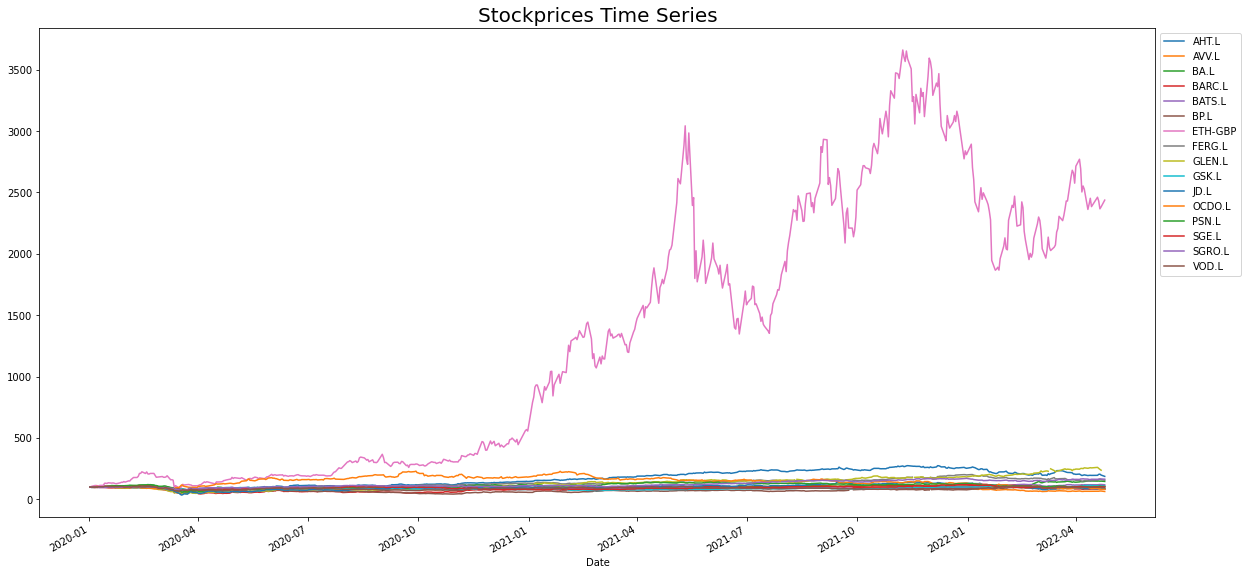

In [8]:
# Plotting the timeseries:
timeseries = prices / prices.iloc[0] * 100
timeseries.plot(figsize=(20, 10))
plt.title('Stockprices Time Series', fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

In [9]:
#Simulation of random portfolio weights:
np.random.seed(42)
weights = np.random.random(size=(n_portfolios, n_assets))
weights /= np.sum(weights, axis=1) [:, np.newaxis]
weights

array([[0.04926945, 0.12506317, 0.09629126, ..., 0.02793247, 0.02391844,
        0.02412623],
       [0.04803233, 0.08284606, 0.06819344, ..., 0.00733337, 0.09591631,
        0.02692154],
       [0.00852728, 0.12438457, 0.12657978, ..., 0.08684667, 0.04086062,
        0.06817307],
       ...,
       [0.04447993, 0.06727287, 0.04112409, ..., 0.0765684 , 0.0954333 ,
        0.05271364],
       [0.06901233, 0.09536022, 0.01555258, ..., 0.09225241, 0.05406621,
        0.07311066],
       [0.03497702, 0.01208885, 0.09936858, ..., 0.04877056, 0.01656329,
        0.12103616]])

In [10]:
portf_returns = np.dot(weights, avg_returns)

portf_vol = np.diag(np.sqrt(np.dot(weights, np.dot(cov_mat, weights.T))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_returns / portf_vol

In [11]:
portf_results = pd.DataFrame({'returns': portf_returns,
                             'volatility': portf_vol,
                             'sharpe_ratio': portf_sharpe_ratio})
portf_results

,returns,volatility,sharpe_ratio
0,0.102879,0.196407,0.523803
1,0.155948,0.187473,0.831843
2,0.172034,0.193217,0.890365
3,0.192729,0.202255,0.952905
4,0.187988,0.223071,0.842725
...,...,...,...
4995,0.268600,0.223954,1.199358
4996,0.178428,0.210656,0.847010
4997,0.150541,0.191871,0.784597
4998,0.162119,0.191937,0.844648


In [12]:
n_points = 20
portf_vol_ef = []
indices_to_skip = []

portf_returns_ef = np.linspace(portf_results.returns.min(),
                               portf_results.returns.max(),
                               n_points)
portf_rerturns_ef = np.round(portf_returns_ef, 2)
portf_returns = np.round(portf_returns, 2)

for point_index in range (n_points):
    if portf_returns_ef[point_index] not in portf_returns:
       indices_to_skip.append(point_index)
       continue
    matched_ind = np.where(portf_returns ==
                           portf_returns_ef[point_index])
    
portf_returns_ef = np.delete(portf_returns_ef, indices_to_skip)

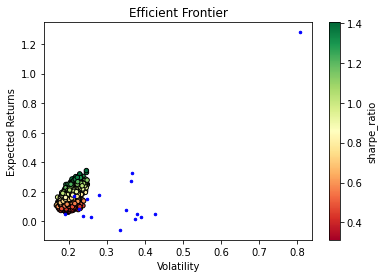

In [13]:
marks = ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']


fig, ax = plt.subplots()
portf_results.plot(kind='scatter', 
                   x='volatility', 
                   y='returns', 
                   c='sharpe_ratio', 
                   cmap='RdYlGn', 
                   edgecolors='black', 
                   ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_returns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),
               y=avg_returns[asset_index],
               marker=marks[asset_index],
               s=25,
               color='blue',
               label=())

In [14]:
max_sharpe_ind = np.argmax(portf_results.sharpe_ratio)
max_sharpe_portf = portf_results.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results.volatility)
min_vol_portf = portf_results.loc[min_vol_ind]

In [15]:
print ('Maximum Sharpe Ratio portfolio ----')
print ('Performance')
for index, value in max_sharpe_portf.items() :
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(assets,
weights[np.argmax(portf_results.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 32.14% volatility: 22.91% sharpe_ratio: 140.31% 
Weights
AHT.L: 8.69% AVV.L: 3.53% BA.L: 2.29% BARC.L: 3.59% BATS.L: 4.15% BP.L: 2.57% ETH-GBP: 15.60% FERG.L: 9.40% GLEN.L: 10.64% GSK.L: 7.38% JD.L: 4.15% OCDO.L: 1.85% PSN.L: 1.50% SGE.L: 3.65% SGRO.L: 16.75% VOD.L: 4.27% 

In [16]:
print ('Minimum Volatility portfolio ----')
print ('Performance')
for index, value in min_vol_portf.items() :
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(assets,
weights[np.argmin(portf_results.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 10.80% volatility: 16.79% sharpe_ratio: 64.35% 
Weights
AHT.L: 2.51% AVV.L: 8.55% BA.L: 2.62% BARC.L: 7.67% BATS.L: 8.91% BP.L: 13.11% ETH-GBP: 0.40% FERG.L: 1.20% GLEN.L: 1.01% GSK.L: 5.24% JD.L: 10.80% OCDO.L: 11.10% PSN.L: 9.69% SGE.L: 11.79% SGRO.L: 4.24% VOD.L: 1.16% 

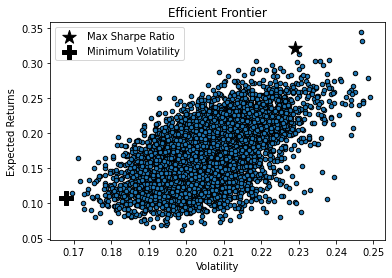

In [17]:
fig, ax = plt.subplots()
portf_results.plot(kind='scatter',
                   x='volatility',
                   y='returns',
                   cmap='RdYlGn',
                   edgecolors='black',
                   ax=ax)
ax.scatter(x=max_sharpe_portf.volatility,
           y=max_sharpe_portf.returns,
           c='black',
           marker='*',
           s=200,
           label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility,
           y=min_vol_portf.returns,
           c='black',
           marker='P',
           s=200,
           label='Minimum Volatility')
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')
ax.legend()

In [18]:
# Define functions for calculating portfolio return and volatility:

def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [19]:
# Define the function calculating theEfficient Frontier:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    efficient_portfolios = []
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range (n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    for ret in rtns_range:
        constraints = ({'type': 'eq',
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq',
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol,
                                           initial_guess,
                                           args=args,
                                           method='SLSQP',
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    return efficient_portfolios

In [20]:
# Define the considered range of returns
rtns_range = np.linspace (0.1, 0.32, 200)

In [21]:
# Calculate the Efficient Frontier
efficient_portfolios = get_efficient_frontier(avg_returns,
                                              cov_mat,
                                              rtns_range)

In [22]:
# Extract the volatilities of the efficient portfolios:
vols_range = [x['fun'] for x in efficient_portfolios]

[Text(0.5, 0, 'Volatility'),
 Text(0, 0.5, 'Expected Returns'),
 Text(0.5, 1.0, 'Efficient Frontier')]

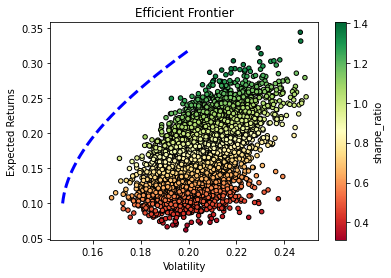

In [23]:
# Plot the calculated Efficient Frontier, together with the simulated portfolios:
fig, ax = plt.subplots()
portf_results.plot(kind='scatter',
                   x='volatility',
                   y='returns',
                   c='sharpe_ratio',
                   cmap='RdYlGn',
                   edgecolors='black',
                   ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')

In [24]:
# Identify the minimum volatility portfolio:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Voltatility': min_vol_portf_rtn,
                 'Sharpe Ratio': (min_vol_portf_rtn /
                                  min_vol_portf_vol)}

In [25]:
# Print the performance summary:
print ('Minimum volatility portfolio ----')
print ('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
    
print('\nWeights')
for x, y in zip (assets,
efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum volatility portfolio ----
Performance
Return: 10.00% Voltatility: 10.00% Sharpe Ratio: 67.82% 
Weights
AHT.L: 0.00% AVV.L: 0.00% BA.L: 12.64% BARC.L: 0.00% BATS.L: 10.46% BP.L: 0.00% ETH-GBP: 0.63% FERG.L: 0.00% GLEN.L: 0.00% GSK.L: 27.46% JD.L: 0.00% OCDO.L: 6.77% PSN.L: 0.00% SGE.L: 10.65% SGRO.L: 25.02% VOD.L: 6.38% 

In [26]:
# Define the objective function for the negative Sharpe Ratio:

def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate) :
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

In [27]:
# Finding the optimized portfolio:
n_assets = len(avg_returns)
rf_rate = 0.01

args = (avg_returns, cov_mat, rf_rate)
constraints = ({'type': 'eq',
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range (n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio,
                                x0=initial_guess,
                                args=args,
                                method='SLSQP',
                                bounds=bounds,
                                constraints=constraints)

In [28]:
# Extracting information about the maximu Sharpe Ratio portfolio:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w,
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                            avg_returns,
                                            cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}

In [29]:
# Printing performance summary:
print ('Maximum Sharpe Ratio portfolio ----')
print ('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100*value:.2f}% ', end="", flush=True)
    
print('\nWeights')
for x, y in zip (assets, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 60.19% Volatility: 34.22% Sharpe Ratio: 172.95% 
Weights
AHT.L: 8.05% AVV.L: 0.00% BA.L: 4.68% BARC.L: 0.00% BATS.L: 0.00% BP.L: 0.00% ETH-GBP: 34.84% FERG.L: 0.00% GLEN.L: 23.39% GSK.L: 0.00% JD.L: 0.00% OCDO.L: 0.00% PSN.L: 0.00% SGE.L: 0.00% SGRO.L: 29.03% VOD.L: 0.00% 

In [30]:
# Convert the annualised average returns and the covariance matrix to numpy arrays:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

In [31]:
# Set up the optimization problem
weights = cp.Variable(n_assets)
gamma = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns @ weights
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
problem = cp.Problem(objective_function,
                     [cp.sum(weights) == 1, weights>= 0])

In [32]:
# Calculate the Efficient Frontier
n_points = 20
portf_rtn_cvx_ef = np.zeros(n_points)
portf_vol_cvx_ef = np.zeros(n_points)
weights_ef = []
gamma_range = np.logspace(-3, 3, num=n_points)

for i in range (n_points) :
    gamma.value = gamma_range[i]
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
    weights_ef.append(weights.value)

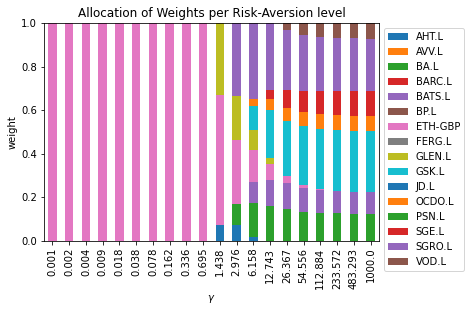

In [33]:
# Plot the allocation for different values of the risk-aversion parameter
weights_df = pd.DataFrame(weights_ef,
                          columns=assets,
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True)
ax.set(title='Allocation of Weights per Risk-Aversion level',
       xlabel=r'$\gamma$',
       ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

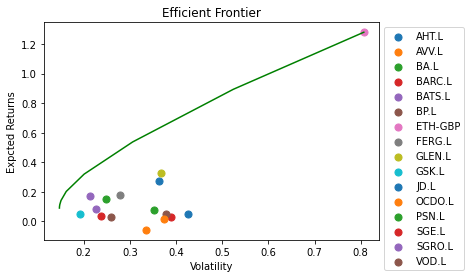

In [34]:
# Plotting the Efficient Frontier with individual assets
MARKS = ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']

fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]),
                 y=avg_returns[asset_index],
                 marker=MARKS[asset_index],
                 label=assets[asset_index],
                 s=200)
ax.set(title='Efficient Frontier',
       xlabel='Volatility',
       ylabel='Expcted Returns', )
ax.legend(bbox_to_anchor=(1,1))

[Text(0.5, 1.0, 'Maximized Risk-Adjusted Retrun'),
 Text(0.5, 0, 'Volatility'),
 Text(0, 0.5, 'Expected Returns'),
 (0.1, 0.5),
 (0.1, 0.75)]

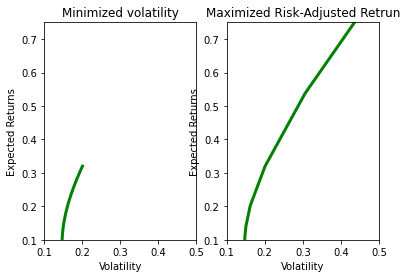

In [35]:
# Efficient frontier comparison
x_lim = [0.1, 0.5]
y_lim = [0.1, 0.75]

fig, ax = plt.subplots(1, 2)
ax[0].plot(vols_range, rtns_range, 'g-', linewidth=3)
ax[0].set(title='Minimized volatility',
          xlabel='Volatility',
          ylabel='Expected Returns',
          xlim=x_lim,
          ylim=y_lim)

ax[1].plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-', linewidth=3)
ax[1].set(title='Maximized Risk-Adjusted Retrun',
          xlabel='Volatility',
          ylabel='Expected Returns',
          xlim=x_lim,
          ylim=y_lim)

In [36]:
# Analysing maximum allowable leverage
max_leverage= cp.Parameter()
problem_with_leverage = cp.Problem(objective_function,
                                   [cp.sum(weights) == 1,
                                    cp.norm(weights, 1) <= max_leverage])

In [37]:
# Redefining objects in order to store the results to be either larger 2D matrices or 3 = [1, 2, 5]
leverage_range = [1, 3, 5]
len_leverage = len(leverage_range)
n_points = 20

portf_vol_l_ef = np.zeros((n_points, len_leverage))
portf_rtn_l_ef = np.zeros((n_points, len_leverage))
weights_ef =np.zeros((len_leverage, n_points, n_assets))

for lev_ind, leverage in enumerate(leverage_range) :
    for gamma_ind in range(n_points):
        max_leverage.value = leverage
        gamma.value = gamma_range[gamma_ind]
        problem_with_leverage.solve(verbose=True)
        portf_vol_l_ef[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l_ef[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) May 16 07:23:20 AM: Your problem has 16 variables, 2 constraints, and 2 parameters.
(CVXPY) May 16 07:23:20 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 16 07:23:20 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 16 07:23:20 AM: Compiling problem (target solver=OSQP).
(CVXPY) May 16 07:23:20 AM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) May 16 07:23:20 AM: Applying reduction FlipObjective
(CVXPY) May 16 07:23:20 AM: Applying reductio

C:\Users\Szenes Ibolya\anaconda3\envs\diss\lib\site-packages\cvxpy\problems\problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



(CVXPY) May 16 07:23:20 AM: Your problem has 16 variables, 2 constraints, and 2 parameters.
(CVXPY) May 16 07:23:20 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 16 07:23:20 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 16 07:23:20 AM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) May 16 07:23:20 AM: Finished problem compilation (took 2.597e-03 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) May 16 07:23:20 AM: In

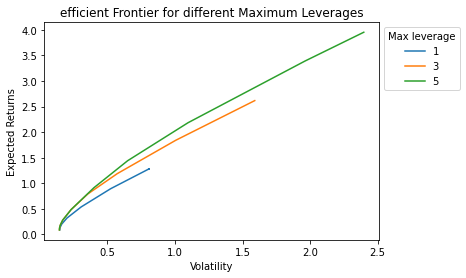

In [38]:
# Efficient frontiers for dfferent maximum leverages
fig, ax=plt.subplots()

for leverage_index, leverage in enumerate(leverage_range):
    plt.plot(portf_vol_l_ef[:, leverage_index],
            portf_rtn_l_ef[:, leverage_index],
            label=f'{leverage}')
    
ax.set(title='efficient Frontier for different Maximum Leverages',
       xlabel='Volatility',
       ylabel='Expected Returns')
ax.legend(title='Max leverage',
          bbox_to_anchor=(1,1))

Text(0.5, 1.0, 'Weights allocation per risk-aversion level')

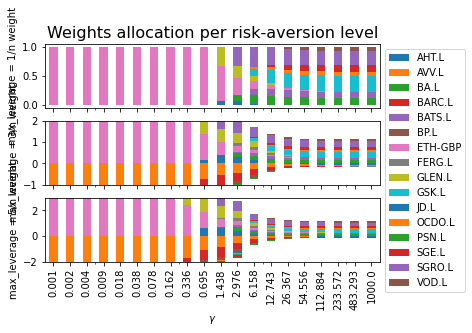

In [39]:
# Plotting weight allocation per varying risk-aversion levels
fig, ax = plt.subplots(len_leverage, 1, sharex=True)

for ax_index in range(len_leverage):
    weights_df = pd.DataFrame (weights_ef[ax_index],
                               columns=assets,
                               index=np.round(gamma_range, 3))
    weights_df.plot(kind='bar',
                    stacked=True,
                    ax=ax[ax_index],
                    legend=None)
    ax[ax_index].set(ylabel=(f'max_leverage = {leverage_range[ax_index]}'
                             '/n weight'))
    
ax[len_leverage - 1].set(xlabel=r'$\gamma$')
ax[0].legend(bbox_to_anchor=(1,1))
ax[0].set_title('Weights allocation per risk-aversion level',
                fontsize=16)